<b>Data Sources</b>
* Data on warehouse locations and year built from [Warehouse CITY](https://radicalresearch.shinyapps.io/WarehouseCITY)
* Data on parcels from [San Bernardino Open Data Portal](https://open.sbcounty.gov/datasets/countywide-parcels/about)

In [1]:
# import libraries for notebook
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import random

In [2]:
# import warehouse data downloaded from Warehouse City (https://radicalresearch.shinyapps.io/WarehouseCITY/)
warehouses = pd.read_csv('data/Warehouse_List.csv')

# rename columnn names so that they don't have spaces and are easier to work with
warehouses.rename(columns={'Assessor parcel number':'parcel_num','Building classification':'building_class','Year built':'year',
                           'Acres':'acres','Building sq.ft.':'sqft'},inplace=True)
warehouses.head()

,Category,parcel_num,building_class,year,acres,sqft
0,Planned and Approved,World Logistics Center,TBD,2025,2650,63499000
1,Planned and Approved,Legacy Highlands Phase II Specific Plan,TBD,2025,1386,33207000
2,Planned and Approved,Airport Gateway Specific Plan Area,TBD,2025,613,14689000
3,Planned and Approved,Stoneridge Commerce Center,TBD,2025,606,14523000
4,Planned and Approved,Speedway Commerce Center,TBD,2025,464,11118000


In [3]:
# check if parcel numbers are unique
warehouses.parcel_num.is_unique

False

To figure out how to deal with duplicated parcel numbers we need to understand _why_ they are duplicates. To investigate, we identified duplicate parcel numbers located within San Bernardino County and then mapped them in Python and looked them up in the [County Zoning District Maps](https://sbcounty.maps.arcgis.com/apps/MapSeries/index.html?appid=f5a50c44766b4c36a3ae014497aa430d) to understand what the warehouse presnce looks like in these cases.

In [4]:
# create df with just parcel numbers that are in the dataset multiple times.
duplicate_parcels=warehouses[warehouses.duplicated('parcel_num')]

# import data for all parcels in San Bernadino County downloaded from https://open.sbcounty.gov/datasets/countywide-parcels/about.
sanbernardino = gpd.read_file('data/countywide_parcels/pbmpoly.shp')

# join parcel info onto duplicate parcels to get additional information about duplicates. 
duplicate_parcels.set_index('parcel_num',inplace=True)
sanbernardino.rename(columns={'APN':'parcel_num'},inplace=True)
sanbernardino.set_index('parcel_num',inplace=True)
duplicate_parcels=duplicate_parcels.join(sanbernardino,how='left')

# create new df with just duplicated parcels within san bernardino and their addresses
duplicate_sb_addresses=duplicate_parcels[duplicate_parcels['OWNER_NAME'].notna()].set_geometry('geometry')
duplicate_sb_addresses.head()

,Category,building_class,year,acres,sqft,OWNER_NAME,NUMBER,PREDIR,STREETNAME,STREETTYPE,...,TAX_STATUS,TRA,SHAPE_LEN,SHAPE_AREA,LAND_VALUE,IMPR_VALUE,PERS_VALUE,EXEM_VALUE,TYPEUSE,geometry
parcel_num,,,,,,,,,,,,,,,,,,,,,
013639144,Existing,distribution warehouse,2005,8,197000,PROLOGIS-A5 CA I LP,570.0,NaN,MILL,ST,...,1,0007007,4100.334747,1.029490e+06,18787100.0,47872800.0,0.0,0.0,101.0,"POLYGON ((6781148.950 1857839.829, 6781832.716..."
013639144,Existing,distribution warehouse,2005,8,197000,PROLOGIS-A5 CA I LP,570.0,NaN,MILL,ST,...,1,0007007,2792.922625,3.582820e+05,18787100.0,47872800.0,0.0,0.0,101.0,"POLYGON ((6781899.960 1858222.381, 6781901.377..."
013639144,Existing,distribution warehouse,2005,8,197000,PROLOGIS-A5 CA I LP,570.0,NaN,MILL,ST,...,1,0007007,49.653583,7.791250e+01,18787100.0,47872800.0,0.0,0.0,101.0,"POLYGON ((6780889.987 1858215.006, 6780882.486..."
013645118,Existing,distribution warehouse,2021,2,43000,CSHV SHOW PLACE 215 LLC,988.0,S,WASHINGTON,AVE,...,1,0007014,1179.354421,7.849537e+04,5200000.0,17800000.0,0.0,0.0,101.0,"POLYGON ((6778091.225 1853645.184, 6778477.849..."
013645118,Existing,distribution warehouse,2021,2,43000,CSHV SHOW PLACE 215 LLC,988.0,S,WASHINGTON,AVE,...,1,0007014,1766.312204,1.919883e+05,5200000.0,17800000.0,0.0,0.0,101.0,"POLYGON ((6778480.158 1853446.492, 6778485.804..."


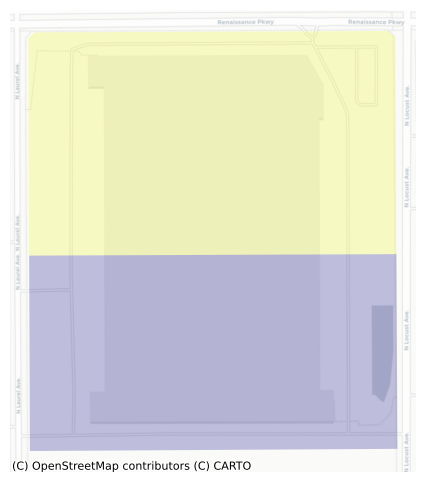

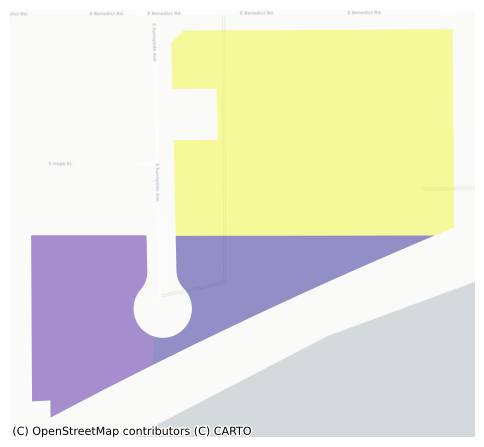

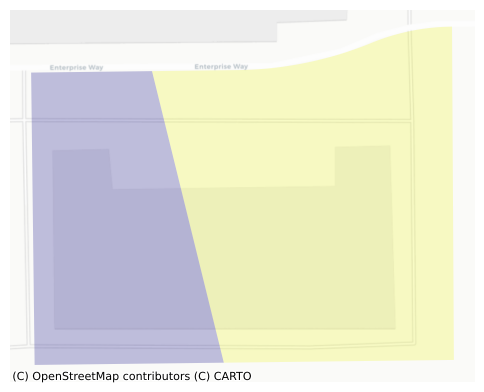

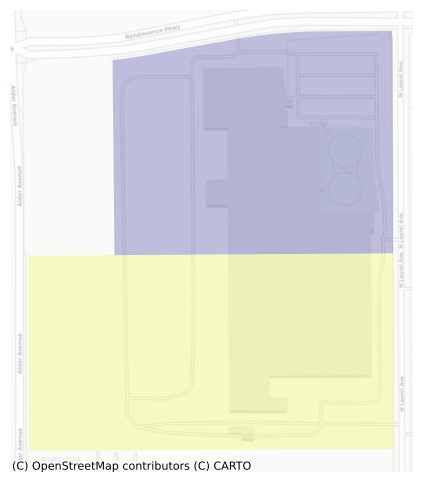

In [5]:
# get four random parcel_numbers from the df of duplicates in san bernardino with addresses and then plot them
parcels_to_map=duplicate_sb_addresses.groupby(level=0).size().index.values.tolist()
random=random.sample(range(0, len(parcels_to_map)-1), 4)
for i in (random):
    fig, ax = plt.subplots(figsize=(6,6))
    duplicate_sb_addresses.loc[parcels_to_map[i]].plot(ax=ax,column='SHAPE_AREA',cmap='plasma',alpha=0.25)
    ax.axis('off')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,crs=2229)

Between the simple maps above and some additional research in the [County Zoning District Maps](https://sbcounty.maps.arcgis.com/apps/MapSeries/index.html?appid=f5a50c44766b4c36a3ae014497aa430d) we have confirmed that the duplicated Assessor Numbers are associated with parcels with multiple subdivisions with warehouses on them. There are two options here:
1. Aggregate warehouse information to the parcel number
2. Do all analysis at the parcel subdivision level

The group will have to consult to make a decision on how we want to proceed with data cleaning, but for now I'm going to finish creating a dataset at the parcel number level. 

In [6]:
# get category and buiding class associated with each parcel.
warehouse_clean=warehouses.groupby('parcel_num')[['Category','building_class']].first()
# get first year that a warehouse was built on the parcel.
year=warehouses.groupby('parcel_num')[['year']].min()
# get total acres of warehouses built on the parcel.
area=warehouses.groupby('parcel_num')[['acres','sqft']].sum()
# join all of these column together on parcel_id.
warehouse_clean=warehouse_clean.join(year).join(area)
warehouse_clean.head()

,Category,building_class,year,acres,sqft
parcel_num,,,,,
011011113,Existing,storage warehouse,2021,2,41000
011011114,Existing,storage warehouse,2021,2,39000
011012110,Existing,distribution warehouse,1982,4,106000
011031145,Existing,distribution warehouse,2016,8,187000
011031146,Existing,distribution warehouse,2016,25,589000


In [7]:
# save csv so it can be used in other notebooks.
warehouse_clean.to_csv('warehouse_by_parcel.csv')